# Predicting dynamic samples

TCSPC-FLIM images of **freely moving** *C. elegans* mounted on agarose plates without any chemical immobilisation.
<br>Images are aquired over **1 second**.

Two conditions are imaged:

1.  *C. elegans* expressing the fluorophore **mScarlet** in its neurons 
2.  *C. elegans* expressing the fluorophore **mScarlet tagged to amyloid-beta (Aβ)**, a protein linked to Alzheimer’s disease, in its neurons

As Aβ is prone to aggregation, the mScarlet tagged Aβ is expected to display shorter fluorescence lifetimes, indicating a higher aggregated state.

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

current_folder = globals()['_dh'][0]
print(current_folder)
os.chdir(os.path.join(current_folder, '..'))

C:\Users\User\Desktop\PhD\Projects\dl_flim\FLIMngo\demo_notebooks


In [2]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from utils.eval_utils import load_sdt, load_tiff, mask_data, normalise, visualise_images

from backbone.flimngo_net import GetModel # loads model

In [3]:
# load cuda if available, if not choose cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda


## Data Preprocessing

-	Loading the `.sdt` files.
-	Applying **intensity masks**, which have been prepared by setting a minimum photon count threshold of 10 photons per pixel, followed by manually refining them to remove areas such as unwanted autofluorescence or segments corresponding to other worms present in the field of view.
-	The time dimension is **normalised** between 0 and 1.
-	The **bin width** (in nanoseconds) is obtained from .sdt metadata.


In [4]:
dir_data = 'sample_data/celegans/raw_data' # directory where data are stored
dir_masks = 'sample_data/celegans/masks' # directory for intensity masks

In [5]:
data_dict = {} # initiate dictionary to save data

filenames = os.listdir(dir_data) # get list of filenames

# iterate through file names
for file in filenames:

    # remove .sdt extension for the dictionary key
    file_key = os.path.splitext(file)[0]
    
    # laod the raw sdt file and bin width from .sdt temporal metadata
    raw_data, bin_width = load_sdt(dir=dir_data, filename=file)
    # load intensity masks
    mask = load_tiff(dir_masks, filename = file_key + '.tif')
    # mask data
    masked_data =  mask_data(data=raw_data, mask=mask)
    # normalise masked data
    normalised_data = normalise(data=masked_data)

    
    
    # store raw and normalised data into the dictionary with the file names as the keys
    data_dict[file_key] = {
        'raw_data': raw_data,
        'normalised_data': normalised_data,
    }

# get bin width of last .sdt file loaded, should be the same for all data
print(f'bin width:{bin_width} ns')

bin width:0.09765625114122045 ns


In [6]:
data_dict.keys() # prints file names

dict_keys(['abeta_1s_w1', 'abeta_1s_w2', 'abeta_1s_w3', 'abeta_1s_w4', 'abeta_1s_w5', 'abeta_1s_w6', 'mscarlet_1s_w1', 'mscarlet_1s_w2', 'mscarlet_1s_w3', 'mscarlet_1s_w4', 'mscarlet_1s_w5', 'mscarlet_1s_w6'])

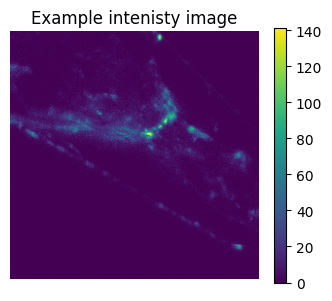

In [7]:
# visualise example intenisty image
# this will ensure that images have been correctly loaded
plt.figure(figsize=(4, 3.3))  # set the figure size
plt.imshow(data_dict['abeta_1s_w5']['raw_data'].sum(0))  # display the summed image (i.e. intensity)
plt.title("Example intenisty image")
plt.colorbar() 
plt.axis('off')
plt.show()

## Predict data

In [8]:
model_id ='flimngo_pretrained_v13102024.pth' # pretrained model id

In [9]:
# set spatial (x,y) dimentions of images, only works for images with identical x and y dimentions
image_dimentions = 256
class Options:
        def __init__(self):
            self.model = 'flimngo'
            self.cpu = not torch.cuda.is_available()  # set to True if you want to use CPU instead of GPU
            self.imageSize = image_dimentions  # set the desired image size 
            self.n_in_channels = 256 # number of time channels should be set to 256
            self.width_multiple = 0.5 
            self.bin_width  =bin_width # bin width (in ns) from .sdt metadata

# Create an instance of the options
opt = Options()
model = GetModel(opt).to(device=device)


In [10]:
# load the FLIMngo pre-trained model
model.load_state_dict(torch.load(model_id, map_location=device))
model.eval()

# iterate through data
for filename in tqdm(list(data_dict.keys()), desc="Predicting simulated data"):
    # prepare the normalised data as a tensor
    data_tensor = torch.tensor(data_dict[filename]['normalised_data'], dtype=torch.float32).unsqueeze(0).to(device)

    # predict fluorescence lifetime
    with torch.no_grad():
        out = model(data_tensor).cpu().numpy()  # Move prediction to CPU and convert to NumPy

    # save the prediction in the dictionary under the same filename
    data_dict[filename]['predicted'] = out


Predicting simulated data: 100%|███████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.14it/s]


## Data Evaluation

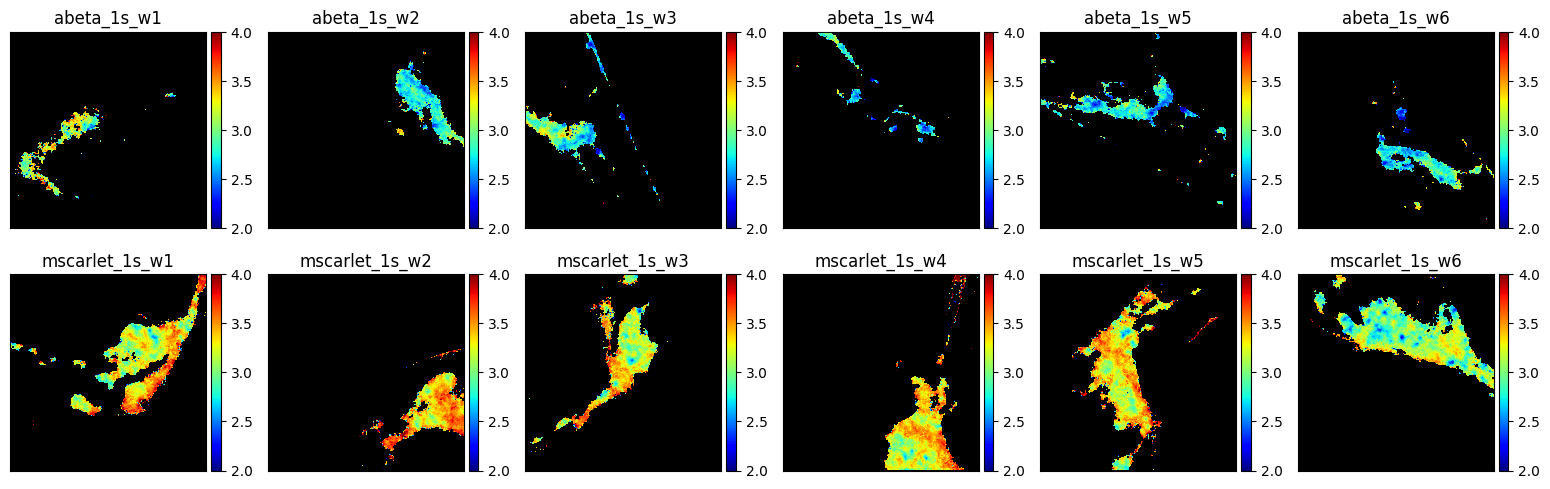

In [11]:
predicted_ls = [data['predicted'] for data in data_dict.values() if 'predicted' in data] # extract predictions and save in list
filenames_ls = [filename for filename, data in data_dict.items() if 'predicted' in data] # get filenames

# visualise images
vmin, vmax = 2, 4 
visualise_images(predicted_ls, filenames_ls, cmap_c='jet', vmin=vmin, vmax=vmax, columns = 6)


In [12]:
# initiate list to save results based on condition (Aβ or mScarlet)
results = []

for file, data in data_dict.items():
    # get predicted data and replace NaNs with zeros
    lifetimes = np.nan_to_num(data['predicted'], nan=0)
    # calculate the mean fluorescence lifetime (excluding zeros)
    mean_lifetime = np.mean(lifetimes[lifetimes!=0])
    
    # extract condition (e.g., 'abeta' or 'mscarlet') from the key
    condition = 'abeta' if 'abeta' in file else 'mscarlet'
    
    # append to results
    results.append({'condition': condition, 'mean_lifetime': mean_lifetime})

# convert to pandas DataFrame
df = pd.DataFrame(results)


In [13]:
# display mean lifetime per condition
df[['mean_lifetime','condition']].groupby('condition').mean()

,mean_lifetime
condition,
abeta,2.817751
mscarlet,3.239768


C:\Users\User\AppData\Local\Temp\ipykernel_25616\2236243129.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["Aβ", "mScarlet"])


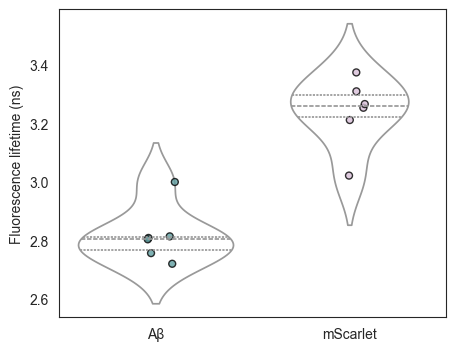

In [14]:
# violin plot 
sns.set_style("white")

fig, ax1 = plt.subplots(figsize=(5, 4))
palette = [ 'cadetblue', "thistle",]

ax1= sns.violinplot(y="mean_lifetime", x="condition", data=df,
                    color="white", saturation=1, inner='quartile')
ax = sns.stripplot(y="mean_lifetime", x="condition",  data=df, hue='condition',  palette=palette,
                    zorder=1, s = 5, alpha = 0.8, edgecolor='#000000', 
                   linewidth=1, ax=ax1)
ax1.set(xlabel='', ylabel=f'Fluorescence lifetime (ns)')
ax1.set_xticklabels(["Aβ", "mScarlet"])
plt.show()